# Import packages & functions

In [1]:
import os
import sys
import json
import argparse
import numpy as np
import math
from einops import rearrange
import time
import random
import string
import h5py
from tqdm import tqdm
import webdataset as wds
import gc

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from accelerate import Accelerator, DeepSpeedPlugin

# # SDXL unCLIP requires code from https://github.com/Stability-AI/generative-models/tree/main
sys.path.append('generative_models/')
import sgm
from generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder
from generative_models.sgm.models.diffusion import DiffusionEngine
from omegaconf import OmegaConf

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# custom functions #
import utils

In [2]:
### Multi-GPU config ###
local_rank = os.getenv('RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print("LOCAL RANK ", local_rank)  

data_type = torch.float16 # change depending on your mixed_precision

## IF NOT USING DEEPSPEED ###
use_deepspeed = False
accelerator = Accelerator(split_batches=False, mixed_precision="fp16") # ['no', 'fp8', 'fp16', 'bf16']
global_batch_size = batch_size = 32

# ### DEEPSPEED INITIALIZATION ###
# use_deepspeed = True
# import deepspeed
# num_devices = torch.cuda.device_count()
# if num_devices==0: num_devices = 1
# if num_devices <= 1 and utils.is_interactive():
#     global_batch_size = batch_size = 32
#     print(f"Setting batch_size to {batch_size}")
#     # can emulate a distributed environment for deepspeed to work in jupyter notebook
#     os.environ["MASTER_ADDR"] = "localhost"
#     os.environ["MASTER_PORT"] = str(np.random.randint(10000)+9000)
#     os.environ["RANK"] = "0"
#     os.environ["LOCAL_RANK"] = "0"
#     os.environ["WORLD_SIZE"] = "1"
#     os.environ["GLOBAL_BATCH_SIZE"] = str(global_batch_size) # set this to your batch size!
# else:
#     global_batch_size = os.environ["GLOBAL_BATCH_SIZE"]    
#     batch_size = int(os.environ["GLOBAL_BATCH_SIZE"]) // num_devices
#     if num_devices <= 1:
#         os.environ["RANK"] = "0"
#         os.environ["LOCAL_RANK"] = "0"
#         os.environ["WORLD_SIZE"] = "1"

# # alter the deepspeed config according to your global and local batch size
# if local_rank == 0:
#     with open('deepspeed_config_stage2_cpuoffload.json', 'r') as file:
#         config = json.load(file)
#     config['train_batch_size'] = int(os.environ["GLOBAL_BATCH_SIZE"])
#     config['train_micro_batch_size_per_gpu'] = batch_size
#     config['bf16'] = {'enabled': False}
#     config['fp16'] = {'enabled': True}
#     with open('deepspeed_config_stage2_cpuoffload.json', 'w') as file:
#         json.dump(config, file)
# else:
#     # give some time for the local_rank=0 gpu to prep new deepspeed config file
#     time.sleep(10)
# deepspeed_plugin = DeepSpeedPlugin("deepspeed_config_stage2_cpuoffload.json")
# accelerator = Accelerator(split_batches=False, deepspeed_plugin=deepspeed_plugin)

LOCAL RANK  0


In [3]:
print("PID of this process =",os.getpid())
device = accelerator.device
print("device:",device)
world_size = accelerator.state.num_processes
distributed = not accelerator.state.distributed_type == 'NO'
num_devices = torch.cuda.device_count()
if num_devices==0 or not distributed: num_devices = 1
num_workers = num_devices
print(accelerator.state)

# set data_type to match your mixed precision (automatically set based on deepspeed config)
if accelerator.mixed_precision == "bf16":
    data_type = torch.bfloat16
elif accelerator.mixed_precision == "fp16":
    data_type = torch.float16
else:
    data_type = torch.float32

print("distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size, "data_type =", data_type)
print = accelerator.print # only print if local_rank=0

PID of this process = 749982
device: cuda
Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

distributed = False num_devices = 1 local rank = 0 world size = 1 data_type = torch.float16


# Configurations

In [4]:
# if running this interactively, can specify jupyter_args here for argparser to use
if utils.is_interactive():
    model_name = "testing"
    print("model_name:", model_name)
    
    # global_batch_size and batch_size should already be defined in the above cells
    # other variables can be specified in the following string:
    # warning that "visualize_prior=True" will only work for >40Gb GPU!
    jupyter_args = f"--data_path=/fsx/proj-fmri/shared/mindeyev2_dataset \
                    --model_name={model_name} \
                    --no-multi_subject --subj=1 --batch_size={batch_size} --no-blurry_recon --no-depth_recon --num_sessions=3 \
                    --clip_scale=1. --blur_scale=100. --depth_scale=100. --hidden_dim=1024 \
                    --seq_past=0 --seq_future=0 \
                    --use_prior --prior_scale=30 --no-visualize_prior \
                    --n_blocks=2 --max_lr=3e-4 --mixup_pct=.33 --num_epochs=12 --ckpt_interval=4 --no-use_image_aug --no-ckpt_saving --no-wandb_log" #--resume_from_ckpt 
    print(jupyter_args)
    jupyter_args = jupyter_args.split()
    
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 

model_name: testing
--data_path=/fsx/proj-fmri/shared/mindeyev2_dataset                     --model_name=testing                     --no-multi_subject --subj=1 --batch_size=32 --no-blurry_recon --no-depth_recon --num_sessions=3                     --clip_scale=1. --blur_scale=100. --depth_scale=100. --hidden_dim=1024                     --seq_past=0 --seq_future=0                     --use_prior --prior_scale=30 --visualize_prior                     --n_blocks=2 --max_lr=3e-4 --mixup_pct=.33 --num_epochs=12 --ckpt_interval=4 --no-use_image_aug --no-ckpt_saving --no-wandb_log


In [5]:
parser = argparse.ArgumentParser(description="Model Training Configuration")
parser.add_argument(
    "--model_name", type=str, default="testing",
    help="name of model, used for ckpt saving and wandb logging (if enabled)",
)
parser.add_argument(
    "--data_path", type=str, default="/fsx/proj-fmri/shared/natural-scenes-dataset",
    help="Path to where NSD data is stored / where to download it to",
)
parser.add_argument(
    "--subj",type=int, default=1, choices=[1,2,3,4,5,6,7,8],
    help="Validate on which subject?",
)
parser.add_argument(
    "--num_sessions", type=int, default=0,
    help="Number of training sessions to include (zero = all sessions)",
)
parser.add_argument(
    "--use_prior",action=argparse.BooleanOptionalAction,default=False,
    help="whether to train diffusion prior (True) or just rely on retrieval part of the pipeline (False)",
)
parser.add_argument(
    "--visualize_prior",action=argparse.BooleanOptionalAction,default=False,
    help="output visualizations from unCLIP every ckpt_interval (requires more memory!)",
)
parser.add_argument(
    "--batch_size", type=int, default=32,
    help="Batch size can be increased by 10x if only training v2c and not diffusion diffuser",
)
parser.add_argument(
    "--wandb_log",action=argparse.BooleanOptionalAction,default=False,
    help="whether to log to wandb",
)
parser.add_argument(
    "--resume_from_ckpt",action=argparse.BooleanOptionalAction,default=False,
    help="if not using wandb and want to resume from a ckpt",
)
parser.add_argument(
    "--wandb_project",type=str,default="stability",
    help="wandb project name",
)
parser.add_argument(
    "--mixup_pct",type=float,default=.33,
    help="proportion of way through training when to switch from BiMixCo to SoftCLIP",
)
parser.add_argument(
    "--low_mem",action=argparse.BooleanOptionalAction,default=False,
    help="whether to preload images to cpu to speed things up but consume more memory",
)
parser.add_argument(
    "--blurry_recon",action=argparse.BooleanOptionalAction,default=True,
    help="whether to output blurry reconstructions",
)
parser.add_argument(
    "--depth_recon",action=argparse.BooleanOptionalAction,default=True,
    help="whether to output depth reconstructions",
)
parser.add_argument(
    "--blur_scale",type=float,default=100.,
    help="multiply loss from blurry recons by this number",
)
parser.add_argument(
    "--depth_scale",type=float,default=100.,
    help="multiply loss from depth recons by this number",
)
parser.add_argument(
    "--clip_scale",type=float,default=1.,
    help="multiply contrastive loss by this number",
)
parser.add_argument(
    "--prior_scale",type=float,default=1,
    help="multiply diffusion prior loss by this",
)
parser.add_argument(
    "--use_image_aug",action=argparse.BooleanOptionalAction,default=True,
    help="whether to use image augmentation",
)
parser.add_argument(
    "--num_epochs",type=int,default=120,
    help="number of epochs of training",
)
parser.add_argument(
    "--multi_subject",action=argparse.BooleanOptionalAction,default=False,
)
parser.add_argument(
    "--new_test",action=argparse.BooleanOptionalAction,default=False,
)
parser.add_argument(
    "--n_blocks",type=int,default=2,
)
parser.add_argument(
    "--hidden_dim",type=int,default=1024,
)
parser.add_argument(
    "--seq_past",type=int,default=0,
)
parser.add_argument(
    "--seq_future",type=int,default=0,
)
parser.add_argument(
    "--lr_scheduler_type",type=str,default='cycle',choices=['cycle','linear'],
)
parser.add_argument(
    "--ckpt_saving",action=argparse.BooleanOptionalAction,default=True,
)
parser.add_argument(
    "--ckpt_interval",type=int,default=5,
    help="save backup ckpt and reconstruct every x epochs",
)
parser.add_argument(
    "--seed",type=int,default=42,
)
parser.add_argument(
    "--max_lr",type=float,default=3e-4,
)

if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()

# create global variables without the args prefix
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)
    
# seed all random functions
utils.seed_everything(seed)

outdir = os.path.abspath(f'../train_logs/{model_name}')
if not os.path.exists(outdir) and ckpt_saving:
    os.makedirs(outdir,exist_ok=True)
    
if use_image_aug:
    import kornia
    from kornia.augmentation.container import AugmentationSequential
    img_augment = AugmentationSequential(
        kornia.augmentation.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1, p=0.3),
        same_on_batch=False,
        data_keys=["input"],
    )
    
if multi_subject:
    subj_list = np.arange(1,9)
    subj_list = subj_list[subj_list != subj]
else:
    subj_list = [subj]

print("subj_list", subj_list, "num_sessions", num_sessions)

subj_list [1] num_sessions 3


# Prep data, models, and dataloaders

### Creating wds dataloader, preload betas and all 73k possible images

In [6]:
def my_split_by_node(urls): return urls
num_voxels_list = []

if multi_subject:
    nsessions_allsubj=np.array([40, 40, 32, 30, 40, 32, 40, 30])
    num_samples_per_epoch = (750*40) // num_devices 
else:
    num_samples_per_epoch = (750*num_sessions) // num_devices 

print("dividing batch size by subj_list, which will then be concatenated across subj during training...") 
batch_size = batch_size // len(subj_list)

num_iterations_per_epoch = num_samples_per_epoch // (batch_size*len(subj_list))

print("batch_size =", batch_size, "num_iterations_per_epoch =",num_iterations_per_epoch, "num_samples_per_epoch =",num_samples_per_epoch)

dividing batch size by subj_list, which will then be concatenated across subj during training...
batch_size = 32 num_iterations_per_epoch = 70 num_samples_per_epoch = 2250


In [7]:
train_data = {}
train_dl = {}
num_voxels = {}
voxels = {}
for s in subj_list:
    print(f"Training with {num_sessions} sessions")
    if multi_subject:
        train_url = f"{data_path}/wds/subj0{s}/train/" + "{0.." + f"{nsessions_allsubj[s-1]-1}" + "}.tar"
    else:
        train_url = f"{data_path}/wds/subj0{s}/train/" + "{0.." + f"{num_sessions-1}" + "}.tar"
    print(train_url)
    
    train_data[f'subj0{s}'] = wds.WebDataset(train_url,resampled=True,nodesplitter=my_split_by_node)\
                        .shuffle(750, initial=1500, rng=random.Random(42))\
                        .decode("torch")\
                        .rename(behav="behav.npy", past_behav="past_behav.npy", future_behav="future_behav.npy", olds_behav="olds_behav.npy")\
                        .to_tuple(*["behav", "past_behav", "future_behav", "olds_behav"])
    train_dl[f'subj0{s}'] = torch.utils.data.DataLoader(train_data[f'subj0{s}'], batch_size=batch_size, shuffle=False, drop_last=True, pin_memory=True)

    # Load hdf5 data for betas, but don't put everything into memory
    f = h5py.File(f'{data_path}/betas_all_subj0{s}_fp32.hdf5', 'r')
    # f = h5py.File(f'{data_path}/betas_subj0{subj}_thresholded_wholebrain.hdf5', 'r')
    
    betas = f['betas'][:]
    betas = torch.Tensor(betas).to("cpu").to(data_type)
    num_voxels_list.append(betas[0].shape[-1])
    num_voxels[f'subj0{s}'] = betas[0].shape[-1]
    voxels[f'subj0{s}'] = betas
    print(f"num_voxels for subj0{s}: {num_voxels[f'subj0{s}']}")

print("Loaded all subj train dls and betas!\n")

# Validate only on one subject
if multi_subject: 
    subj = subj_list[0] # cant validate on the actual held out person so picking first in subj_list
if not new_test: # using old test set from before full dataset released (used in original MindEye paper)
    if subj==3:
        num_test=2113
    elif subj==4:
        num_test=1985
    elif subj==6:
        num_test=2113
    elif subj==8:
        num_test=1985
    else:
        num_test=2770
    test_url = f"{data_path}/wds/subj0{subj}/test/" + "0.tar"
elif new_test: # using larger test set from after full dataset released
    if subj==3:
        num_test=2371
    elif subj==4:
        num_test=2188
    elif subj==6:
        num_test=2371
    elif subj==8:
        num_test=2188
    else:
        num_test=3000
    test_url = f"{data_path}/wds/subj0{subj}/new_test/" + "0.tar"
print(test_url)
test_data = wds.WebDataset(test_url,resampled=False,nodesplitter=my_split_by_node)\
                    .shuffle(750, initial=1500, rng=random.Random(42))\
                    .decode("torch")\
                    .rename(behav="behav.npy", past_behav="past_behav.npy", future_behav="future_behav.npy", olds_behav="olds_behav.npy")\
                    .to_tuple(*["behav", "past_behav", "future_behav", "olds_behav"])
test_dl = torch.utils.data.DataLoader(test_data, batch_size=num_test, shuffle=False, drop_last=True, pin_memory=True)
print(f"Loaded test dl for subj{subj}!\n")

seq_len = seq_past + 1 + seq_future
print(f"currently using {seq_len} seq_len (chose {seq_past} past behav and {seq_future} future behav)")

Training with 3 sessions
/fsx/proj-fmri/shared/mindeyev2_dataset/wds/subj01/train/{0..2}.tar
num_voxels for subj01: 15724
Loaded all subj train dls and betas!

/fsx/proj-fmri/shared/mindeyev2_dataset/wds/subj01/test/0.tar
Loaded test dl for subj1!

currently using 1 seq_len (chose 0 past behav and 0 future behav)


In [8]:
# Load 73k NSD images
f = h5py.File(f'{data_path}/coco_images_224_float16.hdf5', 'r')
images = f['images'][:]
images = torch.Tensor(images).to("cpu").to(data_type)
print("Loaded all 73k possible NSD images to cpu!", images.shape)

Loaded all 73k possible NSD images to cpu! torch.Size([73000, 3, 224, 224])


## Load models

### CLIP image embeddings  model

In [9]:
clip_img_embedder = FrozenOpenCLIPImageEmbedder(
    arch="ViT-bigG-14",
    version="laion2b_s39b_b160k",
    output_tokens=True,
    only_tokens=True,
)
clip_img_embedder.to(device)

clip_seq_dim = 256
clip_emb_dim = 1664

### SD VAE

In [10]:
if blurry_recon:
    from diffusers import AutoencoderKL
    autoenc = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16, cache_dir="/fsx/proj-fmri/shared/cache")
    autoenc.eval()
    autoenc.requires_grad_(False)
    autoenc.to(device)
    utils.count_params(autoenc)

#### MiDaS depth

In [11]:
if depth_recon:
    from controlnet_aux.midas import MidasDetector
    midas_depth = MidasDetector.from_pretrained(
      "valhalla/t2iadapter-aux-models", filename="dpt_large_384.pt", model_type="dpt_large", cache_dir="/fsx/proj-fmri/shared/cache").to(device)
    midas_depth.model.eval()
    midas_depth.model.requires_grad_(False)
    midas_depth.model.to(device)
    pass

### MindEye modules

In [12]:
class MindEyeModule(nn.Module):
    def __init__(self):
        super(MindEyeModule, self).__init__()
    def forward(self, x):
        return x
        
model = MindEyeModule()
model

MindEyeModule()

In [13]:
class RidgeRegression(torch.nn.Module):
    # make sure to add weight_decay when initializing optimizer
    def __init__(self, input_sizes, out_features, seq_len): 
        super(RidgeRegression, self).__init__()
        self.out_features = out_features
        self.linears = torch.nn.ModuleList([
                torch.nn.Linear(input_size, out_features) for input_size in input_sizes
            ])
    def forward(self, x, subj_idx):
        out = torch.cat([self.linears[subj_idx](x[:,seq]).unsqueeze(1) for seq in range(seq_len)], dim=1)
        return out
        
model.ridge = RidgeRegression(num_voxels_list, out_features=hidden_dim, seq_len=seq_len)
utils.count_params(model.ridge)
utils.count_params(model)

# test on subject 1 with fake data
b = torch.randn((2,seq_len,num_voxels_list[0]))
print(b.shape, model.ridge(b,0).shape)

param counts:
16,102,400 total
16,102,400 trainable
param counts:
16,102,400 total
16,102,400 trainable
torch.Size([2, 1, 15724]) torch.Size([2, 1, 1024])


In [14]:
from functools import partial
from diffusers.models.vae import Decoder
class BrainNetwork(nn.Module):
    def __init__(self, out_dim=768, in_dim=15724, seq_len=2, h=4096, n_blocks=n_blocks, drop=.15, 
                 clip_size=768, text_clip_size=768, text_out_dim=768):
        super().__init__()
        self.seq_len = seq_len
        self.h = h
        self.clip_size = clip_size
        self.text_clip_size = text_clip_size
        
        self.mixer_blocks1 = nn.ModuleList([
            self.mixer_block1(h, drop) for _ in range(n_blocks)
        ])
        self.mixer_blocks2 = nn.ModuleList([
            self.mixer_block2(seq_len, drop) for _ in range(n_blocks)
        ])
        
        # Output linear layer
        self.backbone_linear = nn.Linear(h * seq_len, out_dim, bias=True) 
        self.clip_proj = self.projector(clip_size, clip_size, h=clip_size)

        if blurry_recon:
            self.blin1 = nn.Sequential(
                nn.Linear(h, 4096, bias=True),
                nn.LayerNorm(4096),
                nn.GELU(),
                nn.Linear(4096, 4096))
            self.bgroupnorm = nn.GroupNorm(1, 256)
            self.bupsampler = Decoder(
                in_channels=256,
                out_channels=4,
                up_block_types=["UpDecoderBlock2D","UpDecoderBlock2D","UpDecoderBlock2D"],
                block_out_channels=[32, 64, 128],
                layers_per_block=1,
            )

        if depth_recon:
            self.dlin1 = nn.Sequential(
                    nn.Linear(h, 4096),
                    nn.Sigmoid(),
                )
            self.dgroupnorm = nn.GroupNorm(1, 256)
            self.dupsampler = Decoder(
                in_channels=256,
                out_channels=1,
                up_block_types=["UpDecoderBlock2D","UpDecoderBlock2D","UpDecoderBlock2D","UpDecoderBlock2D"],
                block_out_channels=[32, 64, 128, 256],
                layers_per_block=1,
            )
            
    def projector(self, in_dim, out_dim, h=2048):
        return nn.Sequential(
            nn.LayerNorm(in_dim),
            nn.GELU(),
            nn.Linear(in_dim, h),
            nn.LayerNorm(h),
            nn.GELU(),
            nn.Linear(h, h),
            nn.LayerNorm(h),
            nn.GELU(),
            nn.Linear(h, out_dim)
        )
    
    def mlp(self, in_dim, out_dim, drop):
        return nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(out_dim, out_dim),
        )
    
    def mixer_block1(self, h, drop):
        return nn.Sequential(
            nn.LayerNorm(h),
            self.mlp(h, h, drop),  # Token mixing
        )

    def mixer_block2(self, seq_len, drop):
        return nn.Sequential(
            nn.LayerNorm(seq_len),
            self.mlp(seq_len, seq_len, drop)  # Channel mixing
        )

    def ln(self, dim):
        return nn.LayerNorm(dim)
        
    def forward(self, x):
        # make empty tensors for blur and depth outputs
        c,b,d = torch.Tensor([0.]), torch.Tensor([0.]), torch.Tensor([0.])
        
        # Mixer blocks
        residual1 = x
        residual2 = x.permute(0,2,1)
        for block1, block2 in zip(self.mixer_blocks1,self.mixer_blocks2):
            x = block1(x) + residual1
            residual1 = x
            x = x.permute(0,2,1)
            
            x = block2(x) + residual2
            residual2 = x
            x = x.permute(0,2,1)
            
        x = x.reshape(x.size(0), -1)
        backbone = self.backbone_linear(x).reshape(len(x), -1, self.clip_size)
        c = self.clip_proj(backbone)

        if blurry_recon:
            b = self.blin1(x)
            b = b.reshape(len(b), 256, 4, 4)
            b = self.bgroupnorm(b)
            b = self.bupsampler(b)
            
        if depth_recon:
            d = self.dlin1(x)
            d = d.reshape(len(d), 256, 4, 4)
            d = self.dgroupnorm(d)
            d = self.dupsampler(d)
        
        return backbone, c, b, d


model.backbone = BrainNetwork(h=hidden_dim, in_dim=hidden_dim, seq_len=seq_len, 
                          clip_size=clip_emb_dim, out_dim=clip_emb_dim*clip_seq_dim) 
utils.count_params(model.backbone)
utils.count_params(model)

# test that the model works on some fake data
b = torch.randn((2,seq_len,hidden_dim))
print("b.shape",b.shape)

backbone_, clip_, blur_, depth_ = model.backbone(b)
print(backbone_.shape, clip_.shape, blur_.shape, depth_.shape)

param counts:
449,157,772 total
449,157,772 trainable
param counts:
465,260,172 total
465,260,172 trainable
b.shape torch.Size([2, 1, 1024])
torch.Size([2, 256, 1664]) torch.Size([2, 256, 1664]) torch.Size([1]) torch.Size([1])


### Adding diffusion prior + unCLIP if use_prior=True

In [15]:
if use_prior:
    from models import *

    # setup diffusion prior network
    out_dim = clip_emb_dim
    depth = 6
    dim_head = 52
    heads = clip_emb_dim//52 # heads * dim_head = clip_emb_dim
    timesteps = 100

    prior_network = VersatileDiffusionPriorNetwork(
            dim=out_dim,
            depth=depth,
            dim_head=dim_head,
            heads=heads,
            causal=False,
            num_tokens = clip_seq_dim,
            learned_query_mode="pos_emb"
        )

    model.diffusion_prior = BrainDiffusionPrior(
        net=prior_network,
        image_embed_dim=out_dim,
        condition_on_text_encodings=False,
        timesteps=timesteps,
        cond_drop_prob=0.2,
        image_embed_scale=None,
        voxel2clip=None,
    )
    
    utils.count_params(model.diffusion_prior)
    utils.count_params(model)
    
    # prep unCLIP
    if visualize_prior:
        config = OmegaConf.load("generative_models/configs/unclip6.yaml")
        config = OmegaConf.to_container(config, resolve=True)
        unclip_params = config["model"]["params"]
        network_config = unclip_params["network_config"]
        denoiser_config = unclip_params["denoiser_config"]
        first_stage_config = unclip_params["first_stage_config"]
        conditioner_config = unclip_params["conditioner_config"]
        sampler_config = unclip_params["sampler_config"]
        scale_factor = unclip_params["scale_factor"]
        disable_first_stage_autocast = unclip_params["disable_first_stage_autocast"]
        offset_noise_level = unclip_params["loss_fn_config"]["params"]["offset_noise_level"]

        first_stage_config['target'] = 'sgm.models.autoencoder.AutoencoderKL'
        sampler_config['params']['num_steps'] = 38

        diffusion_engine = DiffusionEngine(network_config=network_config,
                               denoiser_config=denoiser_config,
                               first_stage_config=first_stage_config,
                               conditioner_config=conditioner_config,
                               sampler_config=sampler_config,
                               scale_factor=scale_factor,
                               disable_first_stage_autocast=disable_first_stage_autocast)
        # set to inference
        diffusion_engine.eval().requires_grad_(False)
        diffusion_engine.to(device)

        ckpt_path = '/fsx/proj-fmri/shared/mindeyev2_dataset/unclip6_epoch0_step110000.ckpt'
        ckpt = torch.load(ckpt_path, map_location='cpu')
        diffusion_engine.load_state_dict(ckpt['state_dict'])

        image = images[:1].to(device)
        batch={"jpg": image,
              "original_size_as_tuple": torch.ones(image.shape[0], 2).to(device) * 768,
              "crop_coords_top_left": torch.zeros(image.shape[0], 2).to(device)}
        out = diffusion_engine.conditioner(batch)
        vector_suffix = out["vector"].to(device)
        print("vector_suffix", vector_suffix.shape)

param counts:
259,865,216 total
259,865,200 trainable
param counts:
725,125,388 total
725,125,372 trainable


Initialized embedder #0: FrozenOpenCLIPImageEmbedder with 1909889025 params. Trainable: False
Initialized embedder #1: ConcatTimestepEmbedderND with 0 params. Trainable: False
Initialized embedder #2: ConcatTimestepEmbedderND with 0 params. Trainable: False
vector_suffix torch.Size([1, 1024])


### Setup optimizer / lr / ckpt saving

In [16]:
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']

if use_prior:
    opt_grouped_parameters = [
        {'params': [p for n, p in model.ridge.named_parameters()], 'weight_decay': 1e-2},
        {'params': [p for n, p in model.backbone.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
        {'params': [p for n, p in model.backbone.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
        {'params': [p for n, p in model.diffusion_prior.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
        {'params': [p for n, p in model.diffusion_prior.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
    ]
else:
    opt_grouped_parameters = [
        {'params': [p for n, p in model.ridge.named_parameters()], 'weight_decay': 1e-2},
        {'params': [p for n, p in model.backbone.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
        {'params': [p for n, p in model.backbone.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
    ]

optimizer = torch.optim.AdamW(opt_grouped_parameters, lr=max_lr)

if lr_scheduler_type == 'linear':
    lr_scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer,
        total_iters=int(np.floor(num_epochs*num_iterations_per_epoch)),
        last_epoch=-1
    )
elif lr_scheduler_type == 'cycle':
    total_steps=int(np.floor(num_epochs*num_iterations_per_epoch))
    print("total_steps", total_steps)
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=max_lr,
        total_steps=total_steps,
        final_div_factor=1000,
        last_epoch=-1, pct_start=2/num_epochs
    )
    
def save_ckpt(tag):
    if use_deepspeed:
        deepspeed.DeepSpeedEngine.save_checkpoint(model, save_dir=outdir, tag=tag)
        ckpt_path = outdir+f'/{tag}/{tag}.npy'
        np.save(ckpt_path, {
            'epoch': epoch,
            'train_losses': losses,
            'test_losses': test_losses,
            'lrs': lrs})
    else:
        ckpt_path = outdir+f'/{tag}.pth'
        unwrapped_model = accelerator.unwrap_model(model)
        torch.save({
            'epoch': epoch,
            'model_state_dict': unwrapped_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler': lr_scheduler.state_dict(),
            'train_losses': losses,
            'test_losses': test_losses,
            'lrs': lrs,
            }, ckpt_path)
        del unwrapped_model
    print(f"\n---saved {outdir}/{tag} ckpt!---\n")

def load_ckpt(tag,load_lr=True,load_optimizer=True,load_epoch=True,strict=True): 
    print(f"\n---loading {outdir}/{tag}.pth ckpt---\n")
    if use_deepspeed:
        state_dict = deepspeed.utils.zero_to_fp32.get_fp32_state_dict_from_zero_checkpoint(checkpoint_dir=outdir, tag=tag)
        try:
            model.module.load_state_dict(state_dict, strict=strict)
        except:
            model.load_state_dict(state_dict, strict=strict)
        if load_epoch:
            np_ckpt = np.load(outdir+f'/{tag}/{tag}.npy', allow_pickle=True).tolist()
            globals()["epoch"] = np_ckpt['epoch']
            print("Epoch",epoch)
    else:
        checkpoint = torch.load(outdir+'/last.pth', map_location='cpu')
        if load_epoch:
            globals()["epoch"] = checkpoint['epoch']
            print("Epoch",epoch)
        if load_optimizer:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if load_lr:
            lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
        try:
            model.module.load_state_dict(state_dict, strict=strict)
        except:
            model.load_state_dict(state_dict, strict=strict)
        del checkpoint
        
print("\nDone with model preparations!")
num_params = utils.count_params(model)

total_steps 840

Done with model preparations!
param counts:
725,125,388 total
725,125,372 trainable


# Weights and Biases

In [17]:
if local_rank==0 and wandb_log: # only use main process for wandb logging
    import wandb
    wandb_project = 'mindeye'
    print(f"wandb {wandb_project} run {model_name}")
    # need to configure wandb beforehand in terminal with "wandb init"!
    wandb_config = {
      "model_name": model_name,
      "global_batch_size": global_batch_size,
      "batch_size": batch_size,
      "num_epochs": num_epochs,
      "num_sessions": num_sessions,
      "num_params": num_params,
      "clip_scale": clip_scale,
      "prior_scale": prior_scale,
      "blur_scale": blur_scale,
      "use_image_aug": use_image_aug,
      "max_lr": max_lr,
      "mixup_pct": mixup_pct,
      "num_samples_per_epoch": num_samples_per_epoch,
      "num_test": num_test,
      "ckpt_interval": ckpt_interval,
      "ckpt_saving": ckpt_saving,
      "seed": seed,
      "distributed": distributed,
      "num_devices": num_devices,
      "world_size": world_size,
      "train_url": train_url,
      "test_url": test_url,
    }
    print("wandb_config:\n",wandb_config)
    print("wandb_id:",model_name)
    wandb.init(
        project=wandb_project,
        name=model_name,
        config=wandb_config,
        resume="allow",
    )
else:
    wandb_log = False

# Main

In [18]:
epoch = 0
losses, test_losses, lrs = [], [], []
best_test_loss = 1e9
torch.cuda.empty_cache()

In [19]:
# load saved ckpt model weights into current model
if resume_from_ckpt:
    load_ckpt("last",load_lr=True,load_optimizer=True,load_epoch=True)
elif wandb_log:
    if wandb.run.resumed:
        load_ckpt("last",load_lr=True,load_optimizer=True,load_epoch=True)

In [20]:
train_dls = [train_dl[f'subj0{s}'] for s in subj_list]

model, optimizer, *train_dls, lr_scheduler = accelerator.prepare(model, optimizer, *train_dls, lr_scheduler)
# leaving out test_dl since we will only have local_rank 0 device do evals

testing starting with epoch 0 / 12


  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

---
reconstructing... idx=2


/admin/home-paulscotti/mindeye/lib/python3.11/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/admin/home-paulscotti/mindeye/lib/python3.11/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


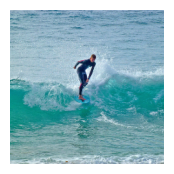

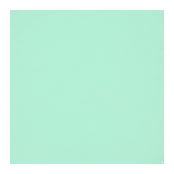

 17%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  | 2/12 [06:38<32:43, 196.32s/it, test/blurry_pixcorr=0, test/depth_pixcorr=0, test/loss=25.2, test/loss_blurry_total=0, test/loss_clip_total=3.44, test/loss_depth_total=0, test/loss_prior=21.7, test/num_steps=2, test/recon_cossim=0.158, test/recon_mse=1.33, test/test_bwd_pct_correct=0.123, test/test_fwd_pct_correct=0.44, train/blurry_pixcorr=0, train/bwd_pct_correct=0.295, train/depth_pixcorr=0, train/fwd_pct_correct=0.526, train/l

---


 17%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | 2/12 [09:39<32:43, 196.32s/it, test/blurry_pixcorr=0, test/depth_pixcorr=0, test/loss=24.1, test/loss_blurry_total=0, test/loss_clip_total=2.48, test/loss_depth_total=0, test/loss_prior=21.6, test/num_steps=3, test/recon_cossim=0.157, test/recon_mse=1.47, test/test_bwd_pct_correct=0.27, test/test_fwd_pct_correct=0.577, train/blurry_pixcorr=0, train/bwd_pct_correct=0.556, train/depth_pixcorr=0, train/fwd_pct_correct=0.61, train/loss

---


 25%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                 | 3/12 [12:42<28:29, 189.92s/it, test/blurry_pixcorr=0, test/depth_pixcorr=0, test/loss=18.7, test/loss_blurry_total=0, test/loss_clip_total=2.32, test/loss_depth_total=0, test/loss_prior=16.4, test/num_steps=4, test/recon_cossim=0.141, test/recon_mse=1.51, test/test_bwd_pct_correct=0.333, test/test_fwd_pct_correct=0.55, train/blurry_pixcorr=0, train/bwd_pct_correct=0.877, train/depth_pixcorr=0, train/fwd_pct_correct=0.934, train/loss

---


 33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                   | 4/12 [12:43<24:57, 187.14s/it, test/blurry_pixcorr=0, test/depth_pixcorr=0, test/loss=18.7, test/loss_blurry_total=0, test/loss_clip_total=2.32, test/loss_depth_total=0, test/loss_prior=16.4, test/num_steps=4, test/recon_cossim=0.141, test/recon_mse=1.51, test/test_bwd_pct_correct=0.333, test/test_fwd_pct_correct=0.55, train/blurry_pixcorr=0, train/bwd_pct_correct=0.877, train/depth_pixcorr=0, train/fwd_pct_correct=0.934, train/loss

---
reconstructing... idx=0


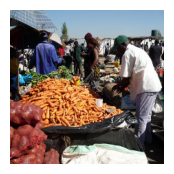

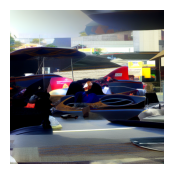

 42%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                     | 5/12 [18:54<21:53, 187.67s/it, test/blurry_pixcorr=0, test/depth_pixcorr=0, test/loss=18.5, test/loss_blurry_total=0, test/loss_clip_total=1.55, test/loss_depth_total=0, test/loss_prior=17, test/num_steps=6, test/recon_cossim=0.124, test/recon_mse=1.62, test/test_bwd_pct_correct=0.527, test/test_fwd_pct_correct=0.71, train/blurry_pixcorr=0, train/bwd_pct_correct=0.979, train/depth_pixcorr=0, train/fwd_pct_correct=0.985, train/loss=

---


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                          | 7/12 [21:57<15:23, 184.75s/it, test/blurry_pixcorr=0, test/depth_pixcorr=0, test/loss=15, test/loss_blurry_total=0, test/loss_clip_total=1.47, test/loss_depth_total=0, test/loss_prior=13.5, test/num_steps=7, test/recon_cossim=0.159, test/recon_mse=1.62, test/test_bwd_pct_correct=0.543, test/test_fwd_pct_correct=0.747, train/blurry_pixcorr=0, train/bwd_pct_correct=0.982, train/depth_pixcorr=0, train/fwd_pct_correct=0.986, train

---


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                         | 8/12 [24:59<12:14, 183.71s/it, test/blurry_pixcorr=0, test/depth_pixcorr=0, test/loss=17.1, test/loss_blurry_total=0, test/loss_clip_total=1.4, test/loss_depth_total=0, test/loss_prior=15.7, test/num_steps=8, test/recon_cossim=0.165, test/recon_mse=1.64, test/test_bwd_pct_correct=0.577, test/test_fwd_pct_correct=0.763, train/blurry_pixcorr=0, train/bwd_pct_correct=0.977, train/depth_pixcorr=0, train/fwd_pct_correct=0.98, train/loss=

---
---
reconstructing... idx=2


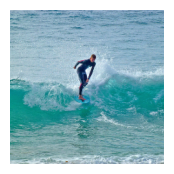

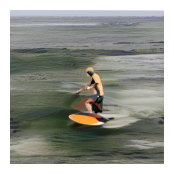

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 10/12 [31:09<06:08, 184.39s/it, test/blurry_pixcorr=0, test/depth_pixcorr=0, test/loss=17.4, test/loss_blurry_total=0, test/loss_clip_total=1.3, test/loss_depth_total=0, test/loss_prior=16.1, test/num_steps=10, test/recon_cossim=0.169, test/recon_mse=1.65, test/test_bwd_pct_correct=0.58, test/test_fwd_pct_correct=0.773, train/blurry_pixcorr=0, train/bwd_pct_correct=0.983, train/depth_pixcorr=0, train/fwd_pct_correct=0.983, train/loss

---


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 11/12 [34:11<03:03, 183.64s/it, test/blurry_pixcorr=0, test/depth_pixcorr=0, test/loss=16.5, test/loss_blurry_total=0, test/loss_clip_total=1.29, test/loss_depth_total=0, test/loss_prior=15.2, test/num_steps=11, test/recon_cossim=0.181, test/recon_mse=1.64, test/test_bwd_pct_correct=0.59, test/test_fwd_pct_correct=0.767, train/blurry_pixcorr=0, train/bwd_pct_correct=0.974, train/depth_pixcorr=0, train/fwd_pct_correct=0.975, train/loss

---
---
reconstructing... idx=2


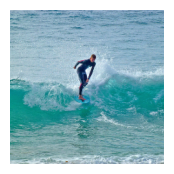

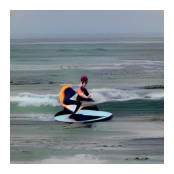

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [37:19<00:00, 186.60s/it, test/blurry_pixcorr=0, test/depth_pixcorr=0, test/loss=16.1, test/loss_blurry_total=0, test/loss_clip_total=1.29, test/loss_depth_total=0, test/loss_prior=14.8, test/num_steps=12, test/recon_cossim=0.182, test/recon_mse=1.64, test/test_bwd_pct_correct=0.593, test/test_fwd_pct_correct=0.763, train/blurry_pixcorr=0, train/bwd_pct_correct=0.988, train/depth_pixcorr=0, train/fwd_pct_correct=0.987, train/loss


===Finished!===



In [21]:
print(f"{model_name} starting with epoch {epoch} / {num_epochs}")
progress_bar = tqdm(range(epoch,num_epochs), ncols=1200, disable=(local_rank!=0))
test_image, test_voxel = None, None
mse = nn.MSELoss()
l1 = nn.L1Loss()
soft_loss_temps = utils.cosine_anneal(0.004, 0.0075, num_epochs - int(mixup_pct * num_epochs))
skip_train = True if epoch>=(num_epochs-1) else False # skip training if you are resuming from a fully trained model

for epoch in progress_bar:
    model.train()

    fwd_percent_correct = 0.
    bwd_percent_correct = 0.
    test_fwd_percent_correct = 0.
    test_bwd_percent_correct = 0.
    
    recon_cossim = 0.
    test_recon_cossim = 0.
    recon_mse = 0.
    test_recon_mse = 0.

    loss_clip_total = 0.
    loss_blurry_total = 0.
    loss_depth_total = 0.
    test_loss_clip_total = 0.
    test_loss_blurry_total = 0.
    test_loss_depth_total = 0.
    
    loss_prior_total = 0.
    test_loss_prior_total = 0.

    blurry_pixcorr = 0.
    test_blurry_pixcorr = 0. # needs >.456 to beat low-level subj01 results in mindeye v1

    depth_pixcorr = 0.
    test_depth_pixcorr = 0.

    # pre-load all batches for this epoch (it's MUCH faster to pre-load in bulk than to separate loading per batch)
    voxel_iters = {} # empty dict because diff subjects have differing # of voxels
    image_iters = torch.zeros(num_iterations_per_epoch, batch_size*len(subj_list), 3, 224, 224).float()
    annot_iters = {}
    perm_iters, betas_iters, select_iters = {}, {}, {}
    for s, train_dl in enumerate(train_dls):
        with torch.cuda.amp.autocast(dtype=data_type):
            for iter, (behav0, past_behav0, future_behav0, old_behav0) in enumerate(train_dl):    
                image0 = images[behav0[:,0,0].cpu().long()].float()
                image_iters[iter,s*batch_size:s*batch_size+batch_size] = image0
                
                voxel0 = voxels[f'subj0{subj_list[s]}'][behav0[:,0,5].cpu().long()]
                voxel0 = torch.Tensor(voxel0)
                
                if seq_len==1:
                    voxel0 = voxel0.unsqueeze(1)
                else:
                    if seq_past>0:
                        past_behavior = past_behav0[:,:(seq_past),5].cpu().long()
                        past_voxel0 = voxels[f'subj0{subj_list[s]}'][past_behavior]
                        past_voxel0[past_behavior==-1] = voxel0[torch.where(past_behavior==-1)[0]] # replace invalid past voxels 
                        past_voxel0 = torch.Tensor(past_voxel0)

                        # if shared100, then you need to mask it out 
                        for p in range(seq_past):
                            mask = (past_behav0[:,p,-1] == 1) # [16,] bool
                            index = torch.nonzero(mask.cpu()).squeeze()
                            past_voxel0[index,p,:] = torch.zeros_like(past_voxel0[index,p,:])

                    if seq_future>0:
                        future_behavior = future_behav0[:,:(seq_future),5].cpu().long()
                        future_voxel0 = voxels[f'subj0{subj_list[s]}'][future_behavior]
                        future_voxel0[future_behavior==-1] = voxel0[torch.where(future_behavior==-1)[0]] # replace invalid past voxels 
                        future_voxel0 = torch.Tensor(future_voxel0)

                        # if shared100, then you need to mask it out 
                        for p in range(seq_future):
                            mask = (future_behav0[:,p,-1] == 1) # [16,] bool
                            index = torch.nonzero(mask.cpu()).squeeze()
                            future_voxel0[index,p,:] = torch.zeros_like(future_voxel0[index,p,:])

                    # concatenate current timepoint with past/future
                    if seq_past > 0 and seq_future > 0:
                        voxel0 = torch.cat((voxel0.unsqueeze(1), past_voxel0), axis=1)
                        voxel0 = torch.cat((voxel0, future_voxel0), axis=1)
                    elif seq_past > 0:
                        voxel0 = torch.cat((voxel0.unsqueeze(1), past_voxel0), axis=1)
                    else:
                        voxel0 = torch.cat((voxel0.unsqueeze(1), future_voxel0), axis=1)

                if epoch < int(mixup_pct * num_epochs):
                    voxel0, perm, betas, select = utils.mixco(voxel0)
                    perm_iters[f"subj0{subj_list[s]}_iter{iter}"] = perm
                    betas_iters[f"subj0{subj_list[s]}_iter{iter}"] = betas
                    select_iters[f"subj0{subj_list[s]}_iter{iter}"] = select

                voxel_iters[f"subj0{subj_list[s]}_iter{iter}"] = voxel0

                if iter >= num_iterations_per_epoch-1:
                    break

    # you now have voxel_iters and image_iters with num_iterations_per_epoch batches each
    if skip_train is False:
        for train_i in range(num_iterations_per_epoch):
            with torch.cuda.amp.autocast(dtype=data_type):
                optimizer.zero_grad()
                loss=0.

                voxel_list = [voxel_iters[f"subj0{s}_iter{train_i}"].detach().to(device) for s in subj_list]
                image = image_iters[train_i].detach().to(device)

                if blurry_recon:
                    ran = np.random.rand()
                    if ran > .66:
                        blurry_image = utils.resize(transforms.GaussianBlur(kernel_size=(15,15),sigma=(12,12))(image), 128)
                    elif ran > .33:
                        blurry_image = utils.resize(transforms.GaussianBlur(kernel_size=(115,115),sigma=(112,112))(image), 128)
                    else:
                        blurry_image = utils.resize(nn.functional.interpolate(image, size=(12, 12), mode='bilinear', align_corners=False), 128)
                    blurry_image_enc = autoenc.encode(2*blurry_image-1).latent_dist.mode() * 0.18215

                if depth_recon:
                    depth_images = utils.resize(midas_depth.model(image).unsqueeze(1), 32) # batch x 1 x 32 x 32
                    depth_images = (depth_images / depth_images.view(depth_images.shape[0], -1).max(dim=1)[0].view(-1, 1, 1, 1).expand_as(depth_images)).half()
                    depth_image = depth_images # autoenc.encode(2*depth_images-1).latents * 0.18215

                if use_image_aug: 
                    image = img_augment(image)

                clip_target = clip_img_embedder(image)
                assert not torch.any(torch.isnan(clip_target))

                if epoch < int(mixup_pct * num_epochs):
                    perm_list = [perm_iters[f"subj0{s}_iter{train_i}"].detach().to(device) for s in subj_list]
                    perm = torch.cat(perm_list, dim=0)
                    betas_list = [betas_iters[f"subj0{s}_iter{train_i}"].detach().to(device) for s in subj_list]
                    betas = torch.cat(betas_list, dim=0)
                    select_list = [select_iters[f"subj0{s}_iter{train_i}"].detach().to(device) for s in subj_list]
                    select = torch.cat(select_list, dim=0)

                voxel_ridge_list = [model.ridge(voxel_list[si],si) for si,s in enumerate(subj_list)]
                voxel_ridge = torch.cat(voxel_ridge_list, dim=0)

                backbone, clip_voxels, blurry_image_enc_, depth_image_ = model.backbone(voxel_ridge)

                if clip_scale>0:
                    clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
                    clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)
                
                if use_prior:
                    loss_prior, prior_out = model.diffusion_prior(text_embed=backbone, image_embed=clip_target)
                    loss_prior *= prior_scale
                    loss += loss_prior
                    loss_prior_total += loss_prior.item()
                    
                    recon_cossim += nn.functional.cosine_similarity(prior_out, clip_target).mean().item()
                    recon_mse += mse(prior_out, clip_target).item()

                if clip_scale>0:
                    if epoch < int(mixup_pct * num_epochs):                
                        loss_clip = utils.mixco_nce(
                            clip_voxels_norm,
                            clip_target_norm,
                            temp=.006,
                            perm=perm, betas=betas, select=select)
                    else:
                        epoch_temp = soft_loss_temps[epoch-int(mixup_pct*num_epochs)]
                        loss_clip = utils.soft_clip_loss(
                            clip_voxels_norm,
                            clip_target_norm,
                            temp=epoch_temp)

                    loss_clip_total += loss_clip.item()
                    loss_clip *= clip_scale
                    loss += loss_clip

                if blurry_recon:
                    loss_blurry = l1(blurry_image_enc_, blurry_image_enc)
                    loss_blurry_total += loss_blurry.item()
                    loss_blurry *= blur_scale
                    loss += loss_blurry

                if depth_recon:
                    loss_depth = l1(depth_image_, depth_image)
                    loss_depth_total += loss_depth.item()
                    loss_depth *= depth_scale
                    loss += loss_depth

                if clip_scale>0:
                    # forward and backward top 1 accuracy        
                    labels = torch.arange(len(clip_voxels_norm)).to(clip_voxels_norm.device) 
                    fwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1).item()
                    bwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1).item()

                if blurry_recon:
                    with torch.no_grad():
                        # only doing pixcorr eval on a subset of the samples per batch because its costly & slow to compute autoenc.decode()
                        random_samps = np.random.choice(np.arange(len(image)), size=batch_size//5, replace=False)
                        blurry_recon_images = (autoenc.decode(blurry_image_enc_[random_samps]/0.18215).sample/ 2 + 0.5).clamp(0,1)
                        pixcorr = utils.pixcorr(image[random_samps], blurry_recon_images)
                        blurry_pixcorr += pixcorr.item()

                if depth_recon:
                    with torch.no_grad():
                        pixcorr = utils.pixcorr(depth_image, depth_image_)
                        depth_pixcorr += pixcorr.item()

                utils.check_loss(loss)
                accelerator.backward(loss)
                optimizer.step()

                losses.append(loss.item())
                lrs.append(optimizer.param_groups[0]['lr'])

                if lr_scheduler_type is not None:
                    lr_scheduler.step()

    model.eval()
    if local_rank==0:
        with torch.no_grad(), torch.cuda.amp.autocast(dtype=data_type): 
            for test_i, (behav, past_behav, future_behav, old_behav) in enumerate(test_dl):  
                # all test samples should be loaded per batch such that test_i should never exceed 0
                assert len(behav) == num_test

                ## Average same-image repeats ##
                if test_image is None:
                    voxel = voxels[f'subj0{subj}'][behav[:,0,5].cpu().long()]
                    
                    if seq_len==1:
                        voxel = voxel.unsqueeze(1)
                    else:
                        if seq_past>0:
                            past_behavior = past_behav[:,:(seq_past),5].cpu().long()
                            past_voxels = voxels[f'subj0{subj}'][past_behavior]
                            if torch.any(past_behavior==-1).item(): # remove invalid voxels (-1 if there is no timepoint available)
                                past_voxels[torch.where(past_behavior==-1)[0]] = 0

                        if seq_future>0:
                            future_behavior = future_behav[:,:(seq_future),5].cpu().long()
                            future_voxels = voxels[f'subj0{subj}'][future_behavior]                    
                            if torch.any(future_behavior==-1).item(): # remove invalid voxels (-1 if there is no timepoint available)
                                future_voxels[torch.where(future_behavior==-1)[0]] = 0
                            
                        if seq_past > 0 and seq_future > 0:
                            voxel = torch.cat((voxel.unsqueeze(1), past_voxels), axis=1)
                            voxel = torch.cat((voxel, future_voxels), axis=1)
                        elif seq_past > 0:
                            voxel = torch.cat((voxel.unsqueeze(1), past_voxels), axis=1)
                        else:
                            voxel = torch.cat((voxel.unsqueeze(1), future_voxels), axis=1)

                    image = behav[:,0,0].cpu().long()

                    unique_image, sort_indices = torch.unique(image, return_inverse=True)
                    for im in unique_image:
                        locs = torch.where(im == image)[0]
                        if len(locs)==1:
                            locs = locs.repeat(3)
                        elif len(locs)==2:
                            locs = locs.repeat(2)[:3]
                        assert len(locs)==3
                        if test_image is None:
                            test_image = images[im][None]
                            test_voxel = voxel[locs][None]
                        else:
                            test_image = torch.vstack((test_image, images[im][None]))
                            test_voxel = torch.vstack((test_voxel, voxel[locs][None]))

                loss=0.
                            
                test_indices = torch.arange(len(test_voxel))[:300]
                voxel = test_voxel[test_indices].to(device)
                image = test_image[test_indices].to(device)
                assert len(image) == 300

                if blurry_recon:
                    blurry_image_enc = autoenc.encode(2*utils.resize(image,128)-1).latent_dist.mode() * 0.18215

                if depth_recon:
                    depth_images = utils.resize(midas_depth.model(image).unsqueeze(1), 32)
                    depth_images = (depth_images / depth_images.view(depth_images.shape[0], -1).max(dim=1)[0].view(-1, 1, 1, 1).expand_as(depth_images)).half()
                    depth_image = depth_images

                clip_target = clip_img_embedder(image.float())

                for rep in range(3):
                    voxel_ridge = model.ridge(voxel[:,rep],0) # 0th index of subj_list
                    backbone0, clip_voxels0, blurry_image_enc_, depth_image_ = model.backbone(voxel_ridge)
                    if rep==0:
                        clip_voxels = clip_voxels0
                        backbone = backbone0
                    else:
                        clip_voxels += clip_voxels0
                        backbone += backbone0
                clip_voxels /= 3
                backbone /= 3

                if clip_scale>0:
                    clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
                    clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)
                
                if use_prior:
                    loss_prior, contaminated_prior_out = model.diffusion_prior(text_embed=backbone[:batch_size], image_embed=clip_target[:batch_size])
                    loss_prior *= prior_scale
                    loss += loss_prior
                    test_loss_prior_total += loss_prior.item()

                    if visualize_prior:
                        # now get unCLIP prediction without feeding it the image embed to get uncontaminated reconstruction
                        prior_out = model.diffusion_prior.p_sample_loop(backbone.shape, 
                                        text_cond = dict(text_embed = backbone), 
                                        cond_scale = 1., timesteps = timesteps)

                        test_recon_cossim += nn.functional.cosine_similarity(prior_out, clip_target).mean().item()
                        test_recon_mse += mse(prior_out, clip_target).item()
                        
                if clip_scale>0:
                    loss_clip = utils.soft_clip_loss(
                        clip_voxels_norm,
                        clip_target_norm,
                        temp=.006)

                    test_loss_clip_total += loss_clip.item()
                    loss_clip = loss_clip * clip_scale
                    loss += loss_clip

                if blurry_recon:
                    loss_blurry = l1(blurry_image_enc_, blurry_image_enc)
                    test_loss_blurry_total += loss_blurry.item()
                    loss_blurry *= blur_scale
                    loss += loss_blurry

                    # halving the batch size because the decoder is computationally heavy
                    blurry_recon_images = (autoenc.decode(blurry_image_enc_[:len(image)//2]/0.18215).sample / 2 + 0.5).clamp(0,1)
                    blurry_recon_images = torch.vstack((blurry_recon_images, (autoenc.decode(blurry_image_enc_[len(image)//2:]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                    pixcorr = utils.pixcorr(image, blurry_recon_images)
                    test_blurry_pixcorr += pixcorr.item()

                if depth_recon:
                    loss_depth = l1(depth_image_, depth_image)
                    test_loss_depth_total += loss_depth.item()
                    loss_depth *= depth_scale
                    loss += loss_depth

                    pixcorr = utils.pixcorr(depth_image, depth_image_)
                    test_depth_pixcorr += pixcorr.item()

                if clip_scale>0:
                    # forward and backward top 1 accuracy        
                    labels = torch.arange(len(clip_voxels_norm)).to(clip_voxels_norm.device) 
                    test_fwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1).item()
                    test_bwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1).item()
                
                utils.check_loss(loss)                
                test_losses.append(loss.item())

            # if utils.is_interactive(): clear_output(wait=True)
            if skip_train: break
            print("---")

            assert (test_i+1) == 1
            logs = {"train/loss": np.mean(losses[-(train_i+1):]),
                "test/loss": np.mean(test_losses[-(test_i+1):]),
                "train/lr": lrs[-1],
                "train/num_steps": len(losses),
                "test/num_steps": len(test_losses),
                "train/fwd_pct_correct": fwd_percent_correct / (train_i + 1),
                "train/bwd_pct_correct": bwd_percent_correct / (train_i + 1),
                "test/test_fwd_pct_correct": test_fwd_percent_correct / (test_i + 1),
                "test/test_bwd_pct_correct": test_bwd_percent_correct / (test_i + 1),
                "train/loss_clip_total": loss_clip_total / (train_i + 1),
                "train/loss_blurry_total": loss_blurry_total / (train_i + 1),
                "test/loss_clip_total": test_loss_clip_total / (test_i + 1),
                "test/loss_blurry_total": test_loss_blurry_total / (test_i + 1),
                "train/blurry_pixcorr": blurry_pixcorr / (train_i + 1),
                "test/blurry_pixcorr": test_blurry_pixcorr / (test_i + 1),
                "train/depth_pixcorr": depth_pixcorr / (train_i + 1),
                "test/depth_pixcorr": test_depth_pixcorr / (test_i + 1),
                "train/loss_depth_total": loss_depth_total / (train_i + 1),
                "test/loss_depth_total": test_loss_depth_total / (test_i + 1),
                "train/recon_cossim": recon_cossim / (train_i + 1),
                "test/recon_cossim": test_recon_cossim / (test_i + 1),
                "train/recon_mse": recon_mse / (train_i + 1),
                "test/recon_mse": test_recon_mse / (test_i + 1),
                "train/loss_prior": loss_prior_total / (train_i + 1),
                "test/loss_prior": test_loss_prior_total / (test_i + 1),
                }

            # if finished training, save jpg recons if they exist
            if (epoch == num_epochs-1) or (epoch % ckpt_interval == 0):
                if blurry_recon:    
                    # transform blurry recon latents to images and plot it
                    fig, axes = plt.subplots(1, 8, figsize=(10, 4))
                    jj=-1
                    for j in [0,1,2,3]:
                        jj+=1
                        axes[jj].imshow(utils.torch_to_Image((autoenc.decode(blurry_image_enc[[j]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                        axes[jj].axis('off')
                        jj+=1
                        axes[jj].imshow(utils.torch_to_Image((autoenc.decode(blurry_image_enc_[[j]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                        axes[jj].axis('off')

                    if wandb_log:
                        logs[f"test/blur_recons"] = wandb.Image(fig, caption=f"epoch{epoch:03d}")
                        plt.close()
                    else:
                        plt.show()

                if depth_recon:
                    # transform blurry recon latents to images and plot it
                    fig, axes = plt.subplots(1, 8, figsize=(10, 4))
                    jj=-1
                    for j in [0,1,2,3]:
                        jj+=1
                        axes[jj].imshow(utils.torch_to_Image(utils.resize(depth_image[[j]].view(1,1,32,32).clamp(0,1), 224)))
                        axes[jj].axis('off')
                        jj+=1
                        axes[jj].imshow(utils.torch_to_Image(utils.resize(depth_image_[[j]].view(1,1,32,32).clamp(0,1), 224)))
                        axes[jj].axis('off')
                    if wandb_log:
                        logs[f"test/depth_recons"] = wandb.Image(fig, caption=f"epoch{epoch:03d}")
                        plt.close()
                    else:
                        plt.show()
                        
                if use_prior and visualize_prior: # output recons every ckpt
                    idx = np.random.randint(0, 3)
                    print(f"reconstructing... idx={idx}")
                    samples = utils.unclip_recon(prior_out[[idx]],
                             diffusion_engine,
                             vector_suffix)
                    if wandb_log:
                        logs[f"test/orig"] = wandb.Image(transforms.ToPILImage()(image[idx]),
                                                           caption=f"epoch{epoch:03d}")
                        logs[f"test/recons"] = wandb.Image(transforms.ToPILImage()(samples[0]),
                                                           caption=f"epoch{epoch:03d}")
                    if utils.is_interactive():
                        plt.figure(figsize=(2,2))
                        plt.imshow(transforms.ToPILImage()(image[idx]))
                        plt.axis('off')
                        plt.show()
                        
                        plt.figure(figsize=(2,2))
                        plt.imshow(transforms.ToPILImage()(samples[0]))
                        plt.axis('off')
                        plt.show()

            progress_bar.set_postfix(**logs)

            if wandb_log: wandb.log(logs)
            
    # Save model checkpoint and reconstruct
    if (ckpt_saving) and (epoch % ckpt_interval == 0):
        save_ckpt(f'last')

    # wait for other GPUs to catch up if needed
    accelerator.wait_for_everyone()
    torch.cuda.empty_cache()
    gc.collect()

print("\n===Finished!===\n")
if ckpt_saving:
    save_ckpt(f'last')
if not utils.is_interactive():
    sys.exit(0)

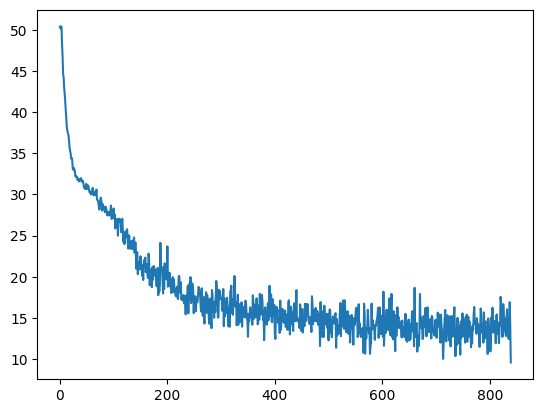

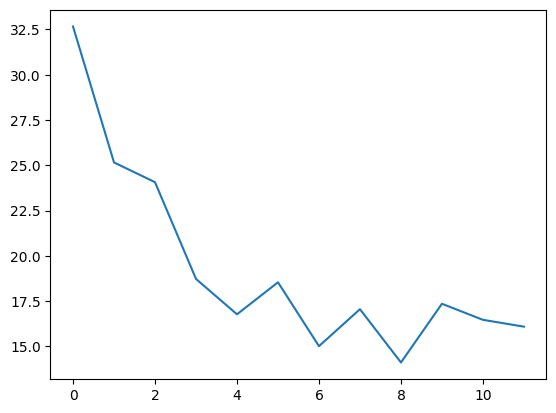

In [22]:
plt.plot(losses)
plt.show()
plt.plot(test_losses)
plt.show()